In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
import matplotlib.pyplot as plt

C:\Users\varsh\AppData\Local\Temp\ipykernel_12956\1535706318.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv(r"C:\Users\varsh\Downloads\ETH-INR.csv")

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop(['Adj Close'], axis=1)
X = data[['Year', 'Month', 'Day', 'Open', 'High', 'Low']]
y = data['Close']

In [5]:
train_size = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [7]:
# Define hyperparameter ranges for tuning (adjust as needed)
param_grid = {
    'kernel': [1.0 * RBF(length_scale=length_scale) for length_scale in np.logspace(-1, 2, 5)],
    'alpha': np.logspace(-3, 2, 5)
}


In [8]:
# Create the RBF Gaussian regressor with grid search for tuning
gp = GaussianProcessRegressor()
grid_search = GridSearchCV(gp, param_grid, cv=5, scoring='neg_mean_squared_error')  # Tune using negative MSE for minimization

In [9]:
# Fit the model with hyperparameter tuning
grid_search.fit(X_train_scaled, y_train_scaled)

C:\Users\varsh\AppData\Roaming\Python\Python312\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\varsh\AppData\Roaming\Python\Python312\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\varsh\AppData\Roaming\Python\Python312\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\varsh\AppData\

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(),
             param_grid={'alpha': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'kernel': [1**2 * RBF(length_scale=0.1),
                                    1**2 * RBF(length_scale=0.562),
                                    1**2 * RBF(length_scale=3.16),
                                    1**2 * RBF(length_scale=17.8),
                                    1**2 * RBF(length_scale=100)]},
             scoring='neg_mean_squared_error')

In [10]:
# Access the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'alpha': 0.001, 'kernel': 1**2 * RBF(length_scale=3.16)}


In [11]:
y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

In [12]:
# Evaluate performance
mse = mean_squared_error(y_test_scaled, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test_scaled, y_pred)
print('R-squared (test):', r2)
r3 = r2_score(y_train_scaled, y_pred_train)
print('R-squared (train):', r3)

Mean Squared Error: 0.059932085654562504
R-squared (test): 0.9534938222129141
R-squared (train): 0.9992230798419713


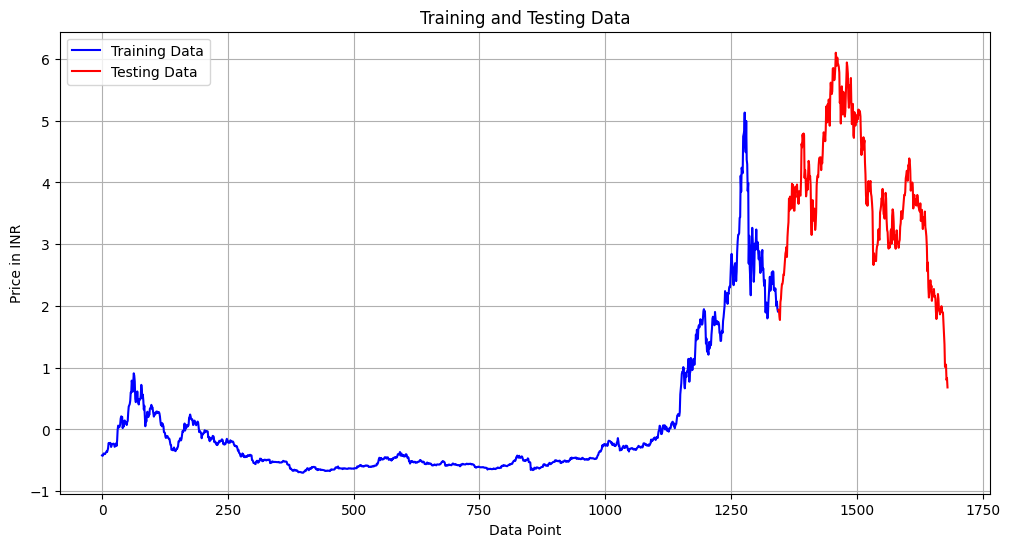

In [17]:
# Plot training and testing data
plt.figure(figsize=(12, 6))
plt.plot(y_train_scaled, label='Training Data', color='blue')
plt.plot(range(len(y_train_scaled), len(y_train_scaled) + len(y_test_scaled)), y_test_scaled, label='Testing Data', color='red')
plt.title('Training and Testing Data')
plt.xlabel('Data Point')
plt.ylabel('Price in INR')
plt.legend()
plt.grid(True)
plt.show()


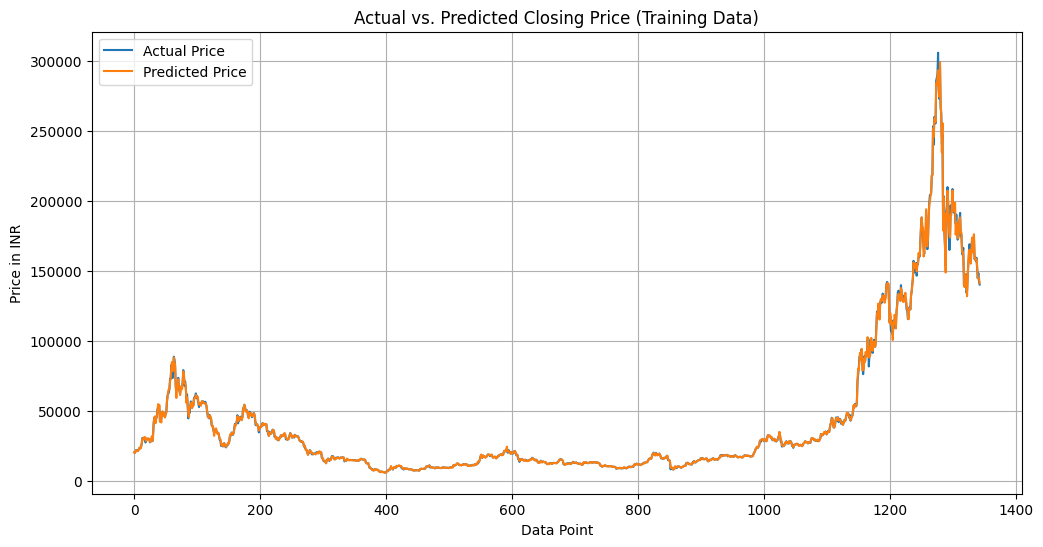

In [21]:
y_pred_train_reshaped = y_pred_train.reshape(-1, 1)

# Inverse transform the scaled predictions for training data to original scale
y_pred_train_inverse = scaler.inverse_transform(y_pred_train_reshaped)

# Plot actual vs. predicted values on the training set
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_train_scaled), label='Actual Price')
plt.plot(y_pred_train_inverse, label='Predicted Price')
plt.title('Actual vs. Predicted Closing Price (Training Data)')
plt.xlabel('Data Point')
plt.ylabel('Price in INR')
plt.legend()
plt.grid(True)
plt.show()

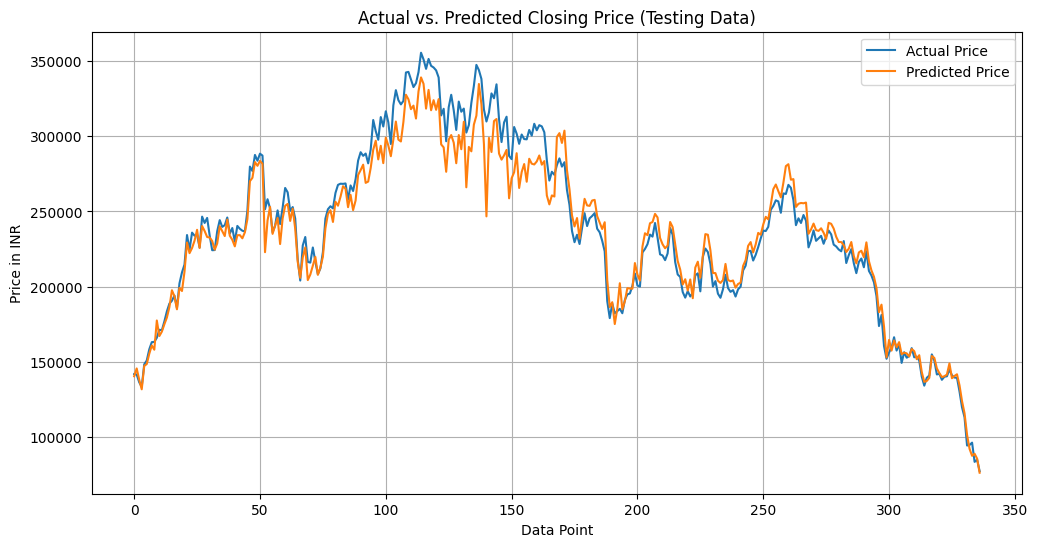

In [23]:
# Reshape y_pred_test to have a single feature
y_pred_test_reshaped = y_pred.reshape(-1, 1)

# Inverse transform the scaled predictions for testing data to original scale
y_pred_test_inverse = scaler.inverse_transform(y_pred_test_reshaped)

# Plot actual vs. predicted values on the testing set
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred_test_inverse, label='Predicted Price')
plt.title('Actual vs. Predicted Closing Price (Testing Data)')
plt.xlabel('Data Point')
plt.ylabel('Price in INR')
plt.legend()
plt.grid(True)
plt.show()